# run on all images

In [1]:
import PyQt5
%matplotlib notebook
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, Normalizer

In [2]:
def show_image(_path):
    img = cv2.imread(_path,1)
    while True:
        cv2.imshow('image',img)
        key = cv2.waitKey(1) & 0xFF
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            # do a bit of cleanup
            cv2.destroyAllWindows()
            break

In [3]:
# Load an color image in grayscale
path = '../processed/data_aligned/'
image_name = 'frame_det_00_000002.bmp'
show_image(path+ image_name)

In [4]:
r_avg = []
g_avg = []
b_avg = []

for image_path in os.listdir(path):
    # create the full input path and read the file
    input_path = os.path.join(path, image_path)
    image_to_display = cv2.imread(input_path)
    
    r_avg.append(np.average(image_to_display[:,:,0]))
    g_avg.append(np.average(image_to_display[:,:,1]))
    b_avg.append(np.average(image_to_display[:,:,2]))
    
r = np.asarray(r_avg).reshape(1,-1) / 255
g = np.asarray(g_avg).reshape(1,-1) / 255
b = np.asarray(b_avg).reshape(1,-1) / 255

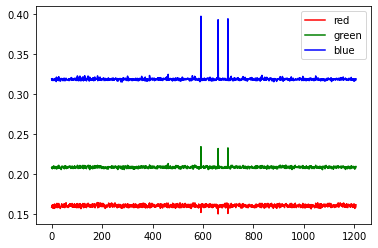

In [5]:
# plot
%matplotlib inline
n_frames = np.arange(len(os.listdir(path))).reshape(1,-1)
plt.plot(n_frames.T, r.T, color='red', label = 'red')
plt.plot(n_frames.T, g.T, color='green', label='green')
plt.plot(n_frames.T, b.T, color='blue', label='blue')
plt.legend()

# plot in real time

In [23]:
import imutils
import cv2
from imutils.video import VideoStream, FileVideoStream
import time
import numpy as np
from jupyterplot import ProgressPlot


# Load the model
modelFile = "../models/res10_300x300_ssd_iter_140000.caffemodel"
configFile = "../models/deploy.prototxt.txt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
confidence_threshold = .7

def stream_rgb(filename=None):
    # To capture video from webcam.
    if not filename:
        vs = VideoStream(src=0).start()
    else:
        # To use a video file as input 
        vs = FileVideoStream(filename).start()
    time.sleep(2.0)
    # set up plotting
    r = []
    g = []
    b = []
    while True:
        # grab frame and resize
        frame = vs.read()
        frame = imutils.resize(frame, width=400)
        # grab the frame dimensions and convert it to a blob
        (h, w) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,
            (300, 300), (104.0, 177.0, 123.0))
        # pass the blob through the network and obtain the detections and
        # predictions
        net.setInput(blob)
        detections = net.forward()
        for i in range(0, detections.shape[2]):
            # extract the confidence (i.e., probability) associated with the
            # prediction
            confidence = detections[0, 0, i, 2]
            # filter out weak detections by ensuring the `confidence` is
            # greater than the minimum confidence
            if confidence < confidence_threshold:
                continue
            # compute the (x, y)-coordinates of the bounding box for the
            # object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            box_im = frame[startY:endY, startX:endX,:]
            # append averages
            r.append(np.average(box_im[:,:,0]) / 255)
            g.append(np.average(box_im[:,:,1]) / 255)
            b.append(np.average(box_im[:,:,2]) / 255)

            # draw the bounding box of the face along with the associated
            # probability
            text = "{:.2f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX, startY), (endX, endY),
                (0, 0, 255), 2)
            cv2.putText(frame, text, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        
        # show the box frame
        cv2.imshow("Frame", box_im)
        # show the frame
#         cv2.imshow("Frame", frame)
        # plot rgb signals 
        num_frames = range(len(r))
        plt.plot(num_frames, r, color='red', label = 'red')
        plt.plot(num_frames, g, color='green', label='green')
        plt.plot(num_frames, b, color='blue', label='blue')
        plt.ylim([0,1])
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            # do a bit of cleanup
            cv2.destroyAllWindows()
            vs.stop()
            break
    return r, g, b

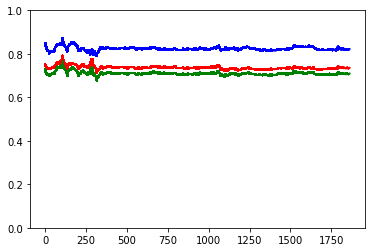

In [24]:
r, g, b = stream_rgb()

# FFT

In [10]:
print(r.shape)

(1, 1208)


In [27]:
from scipy.fft import fft, ifft

num_frames = range(len(r))
fft_r = np.abs(fft(r))
fft_g = fft(g)
fft_b = fft(b)

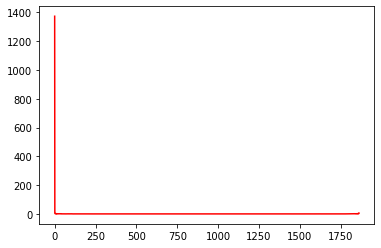

In [28]:
plt.plot(num_frames,fft_r, color='red', label = 'red')
# plt.plot(num_frames, fft_g, color='green', label='green')
# plt.plot(num_frames, fft_b, color='blue', label='blue')